In [20]:
import os

import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import librosa

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [21]:
def augmentation(audio, label):
    audio = tf.squeeze(audio, axis=-1)
    audio = tf.numpy_function(
        func=librosa.effects.pitch_shift,
        inp=[audio, 16000, 2],
        Tout=tf.float32
    )
    audio = tf.expand_dims(audio, axis=-1)
    return audio, label

In [22]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory='assets/augmented_dataset/augmented_dataset',
    shuffle=True,
    validation_split=0.2,
    seed=123,
    batch_size=16,
    subset='both'
)

Found 41849 files belonging to 30 classes.
Using 33480 files for training.
Using 8369 files for validation.


In [23]:
augmented_train_ds = train_ds.map(augmentation)
augmented_val_ds = val_ds.map(augmentation)

In [24]:
lable_names = train_ds.class_names
print(lable_names)

['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvel', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']


Label:  [13 19 21  2  1 29  4  0 29  5  4 10  0 21 29 18]
Audio:  tf.Tensor(
[[[ 1.5258789e-04]
  [ 3.0517578e-04]
  [ 3.6621094e-04]
  ...
  [ 0.0000000e+00]
  [-3.3569336e-04]
  [-2.4414062e-04]]

 [[-3.0517578e-05]
  [ 3.0517578e-05]
  [ 9.1552734e-05]
  ...
  [ 9.1552734e-05]
  [-2.1362305e-04]
  [-4.5776367e-04]]

 [[-1.2207031e-04]
  [-1.8310547e-04]
  [-2.1362305e-04]
  ...
  [ 3.6621094e-04]
  [ 5.1879883e-04]
  [ 5.7983398e-04]]

 ...

 [[ 3.4484863e-03]
  [ 3.8452148e-03]
  [ 1.9226074e-03]
  ...
  [ 1.4953613e-03]
  [ 1.8310547e-04]
  [-5.1879883e-04]]

 [[ 6.5002441e-03]
  [ 7.7209473e-03]
  [ 6.9274902e-03]
  ...
  [-3.9672852e-04]
  [-1.6784668e-03]
  [-1.8005371e-03]]

 [[-1.2207031e-03]
  [-1.4038086e-03]
  [-1.2207031e-03]
  ...
  [ 1.5869141e-03]
  [ 1.4953613e-03]
  [ 1.2512207e-03]]], shape=(16, 16000, 1), dtype=float32)
Spectrogram shape:  (16, 16000, 1)


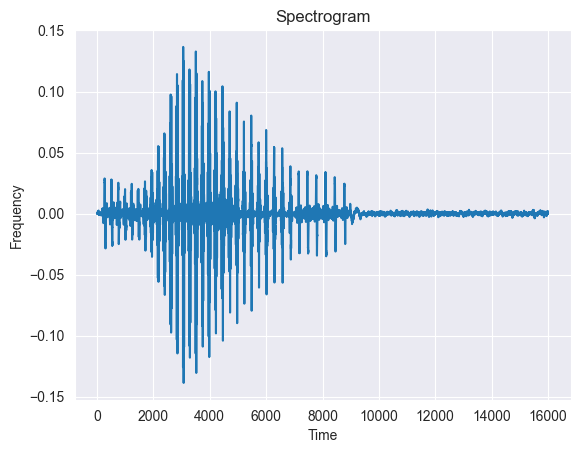

In [25]:
for i, (spectrogram, label) in enumerate(train_ds.take(1)):
    print('Label: ', label.numpy())
    print('Audio: ', spectrogram)
    print('Spectrogram shape: ', spectrogram.shape)
    
    plt.plot(spectrogram[i])
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.title('Spectrogram')
    plt.show()
    

In [26]:
def squeeze(audio, labels):
    return tf.squeeze(audio, axis=-1), labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)


In [27]:
test_ds = val_ds.shard(2, 0)
val_ds = val_ds.shard(2, 1)

In [28]:
for spectrogram, _ in train_ds.take(1):
    spectrogram = tf.signal.stft(spectrogram, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, -1)
    print(spectrogram.shape)

(16, 124, 129, 1)


In [29]:
def get_spec(audio):
    spectrogram = tf.signal.stft(audio, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    return tf.expand_dims(spectrogram, -1)

In [30]:
def spec_ds(ds):
    return ds.map(
        map_func=lambda x, y: (get_spec(x), y), 
        num_parallel_calls=tf.data.AUTOTUNE
    )

In [31]:
train_spec_ds = spec_ds(train_ds)
val_spec_ds = spec_ds(val_ds)
test_spec_ds = spec_ds(test_ds)

In [32]:
train_spec_ds = train_spec_ds.cache().prefetch(tf.data.AUTOTUNE)
val_spec_ds = val_spec_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spec_ds = test_spec_ds.cache().prefetch(tf.data.AUTOTUNE)

In [33]:
input_shape = train_spec_ds.take(1).as_numpy_iterator().next()[0].shape[1:]
num_label = len(lable_names)
print(input_shape, num_label)

norm_layer = layers.experimental.preprocessing.Normalization()
norm_layer.adapt(train_spec_ds.map(lambda x, _: x))


(124, 129, 1) 30


In [34]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.experimental.preprocessing.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_label),
])

In [35]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_1 (Normalizat  (None, 32, 32, 1)        3         
 ion)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)       

In [37]:
epochs = 50

history = model.fit(
    train_spec_ds,
    validation_data=val_spec_ds,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(verbose=1, patience=10),
        tf.keras.callbacks.ModelCheckpoint(
            'assets/models/model.h5', 
            verbose=1,
            save_best_only=True
        )
    ]
)

Epoch 1/50
2093/2093 [==============================] - ETA: 0s - loss: 1.0096 - accuracy: 0.7019
Epoch 1: val_loss improved from inf to 0.28326, saving model to assets/models\model.h5
2093/2093 [==============================] - 53s 25ms/step - loss: 1.0096 - accuracy: 0.7019 - val_loss: 0.2833 - val_accuracy: 0.9308
Epoch 2/50
2093/2093 [==============================] - ETA: 0s - loss: 0.3670 - accuracy: 0.8827
Epoch 2: val_loss improved from 0.28326 to 0.15246, saving model to assets/models\model.h5
2093/2093 [==============================] - 39s 18ms/step - loss: 0.3670 - accuracy: 0.8827 - val_loss: 0.1525 - val_accuracy: 0.9557
Epoch 3/50
2092/2093 [============================>.] - ETA: 0s - loss: 0.2462 - accuracy: 0.9227
Epoch 3: val_loss improved from 0.15246 to 0.10346, saving model to assets/models\model.h5
2093/2093 [==============================] - 38s 18ms/step - loss: 0.2462 - accuracy: 0.9226 - val_loss: 0.1035 - val_accuracy: 0.9703
Epoch 4/50
2090/2093 [==========

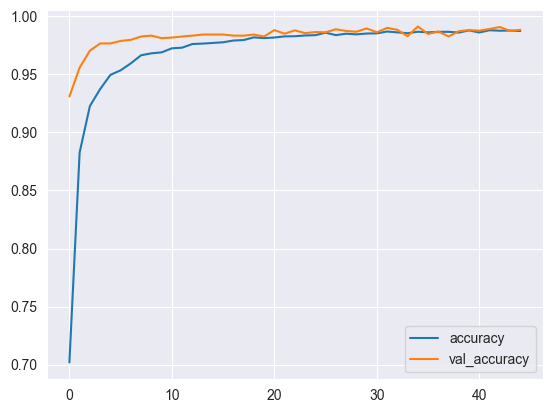

In [38]:
metrics = history.history
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()


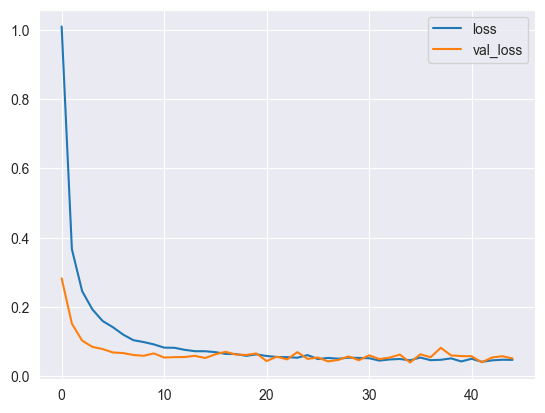

In [39]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [40]:
y_pred = model.predict(test_spec_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_pred = [lable_names[y] for y in y_pred]
y_true = [lable_names[y] for y in (np.concatenate([y for _, y in test_spec_ds], axis=0))]

262/262 [==============================] - 13s 49ms/step


In [41]:
for idx, (y_t, y_p) in enumerate(zip(y_true, y_pred)):
    print(idx, f'Data: %-20s' % y_t, f'Prediction: %-20s' % y_p)


0 Data: eight                Prediction: eight               
1 Data: three                Prediction: three               
2 Data: stop                 Prediction: stop                
3 Data: wow                  Prediction: wow                 
4 Data: three                Prediction: three               
5 Data: house                Prediction: house               
6 Data: left                 Prediction: left                
7 Data: on                   Prediction: on                  
8 Data: bird                 Prediction: bird                
9 Data: on                   Prediction: on                  
10 Data: cat                  Prediction: cat                 
11 Data: down                 Prediction: down                
12 Data: seven                Prediction: seven               
13 Data: up                   Prediction: up                  
14 Data: off                  Prediction: off                 
15 Data: cat                  Prediction: cat                 
16

In [ ]:
# load model yang udah pernah di training

from tensorflow.keras.models import load_model

model = load_model('assets/models/model.h5')
model.predict(test_spec_ds)